# CellRank basics

This tutorial introduces you to CellRank's **high level API** for computing initial & terminal states and fate probabilities. Once we have the fate probabilities, this tutorial shows you how to use them to plot a directed <cite data-cite="wolf:19">PAGA graph</cite>, to compute putative lineage drivers and to visualize smooth gene expression trends. If you want a bit more control over how initial & terminal states and fate probabilities are computed, then you should check out CellRank's **low level API**, composed of [kernels](https://cellrank.readthedocs.io/en/stable/classes.html#kernels) and [estimators](https://cellrank.readthedocs.io/en/stable/classes.html#estimators). This really isn't any more complicated than using scikit-learn, so please do check out the [Kernels and estimators](https://cellrank.readthedocs.io/en/stable/kernels_and_estimators.html) tutorial.

In this tutorial, we will use **RNA velocity and transcriptomic similarity** to estimate cell-cell transition probabilities. Using kernels and estimators, you can apply CellRank even without RNA velocity information, check out our [CellRank beyond RNA velocity](https://cellrank.readthedocs.io/en/stable/beyond_rna_velocity.html) tutorial. CellRank generalizes beyond RNA velocity and is a widely applicable framework to model single-cell data based on the powerful concept of Markov chains. 

The first part of this tutorial is very similar to [scVelo's tutorial on pancreatic endocrinogenesis](https://scvelo-notebooks.readthedocs.io/Pancreas.html). The data we use here comes from <cite data-cite="bastidas-ponce:19">Bastidas-Ponce et al., Development 2018</cite>. For more info on scVelo, see the [documentation](https://scvelo-notebooks.readthedocs.io/index.html) or take a look at <cite data-cite="bergen:20">Bergen et al., Nat. Biotechnol. 2020</cite>. 


This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/cellrank_basics.ipynb).

## Import packages & data

Easiest way to start is to download [Miniconda3](https://docs.conda.io/en/latest/miniconda.html) along with the environment file found [here](https://raw.githubusercontent.com/theislab/cellrank_notebooks/master/environment.yml). To create the environment, run `conda create -f environment.yml`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev
    !pip install python-igraph

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

First, we need to get the data. The following commands will download the `adata` object and save it under `datasets/endocrinogenesis_day15.5.h5ad`. We'll also show the fraction of spliced/unspliced reads, which we need to estimate RNA velocity. 

100%|██████████| 33.5M/33.5M [00:02<00:00, 14.4MB/s]


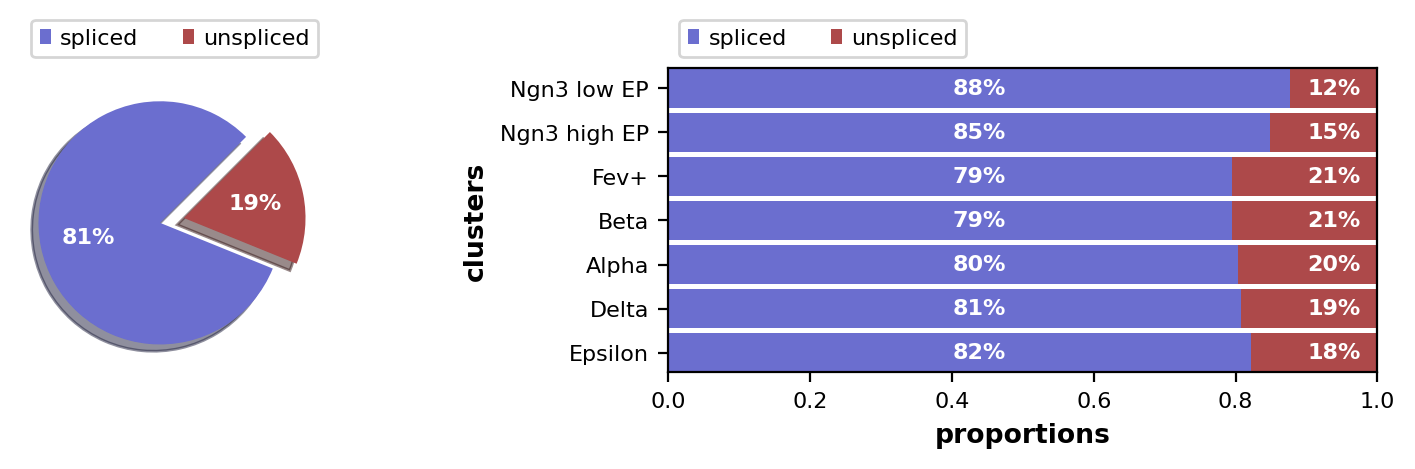

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
adata = cr.datasets.pancreas()
scv.pl.proportions(adata)
adata

## Pre-process the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Run scVelo

We will use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate the velocities. Please make sure to have at least version 0.2.3 of scVelo installed to make use **parallelisation** in `scv.tl.recover_dynamics`. On my laptop, using 8 cores, the below cell takes about 1:30 min to execute. 

In [6]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 2/2 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:03:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the velocities and the velocity graph. The velocity graph is a weighted graph that specifies how likely two cells are to transition into another, given their velocity vectors and relative positions. 

In [7]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


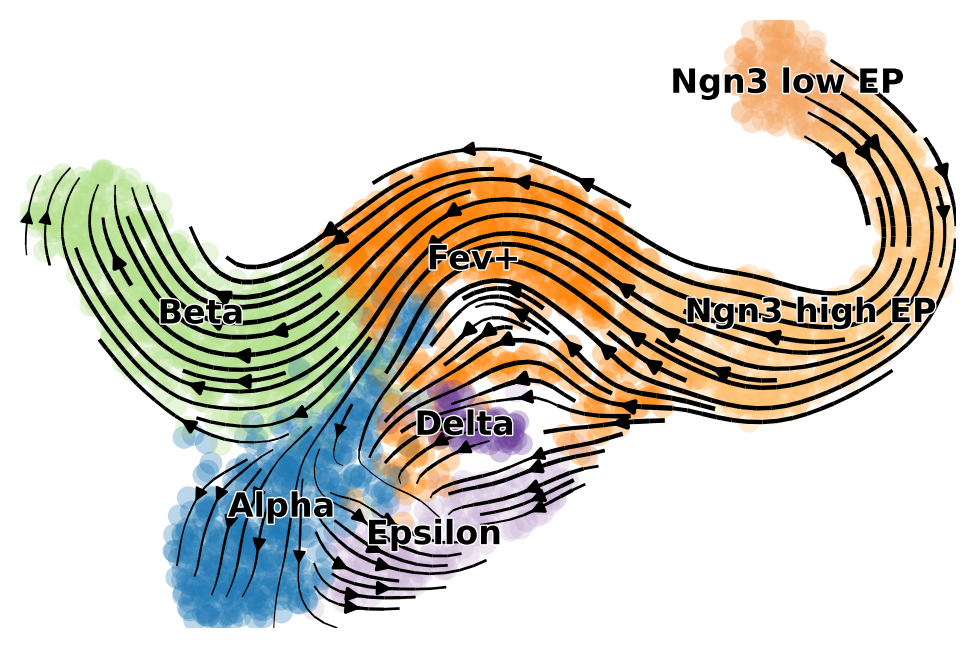

In [8]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4
)

## Run CellRank

CellRank offers various ways to infuse directionality into single-cell data. Here, the directional information comes from RNA velocity, and we use this information to compute initial & terminal states as well as fate probabilities for the dynamical process of pancreatic development. 

## Identify terminal states

Terminal states can be computed by running the following command:

In [9]:
cr.tl.terminal_states(adata, cluster_key="clusters", weight_connectivities=0.2)

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode
Setting `softmax_scale=3.7951`
    Finish (0:00:11)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:11)
Computing `3` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


/tmp/ipykernel_1912/1878820466.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata, cluster_key="clusters", weight_connectivities=0.2)
/home/runner/work/cellrank_notebooks/cellrank_notebooks/cellrank/cellrank/tl/_init_term_states.py:104: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(
100%|██████████| 2531/2531 [00:01<00:00, 1558.62cell/s]


The most important parameters in the above function are:

 - `estimator`: this determines what's going to behind the scenes to compute the terminal states. Options are `cr.tl.estimators.CFLARE` ("Clustering and Filtering of Left and Right Eigenvectors") or `cr.tl.estimators.GPCCA` ("Generalized Perron Cluster Cluster Analysis, <cite data-cite="reuter:18">Reuter et al., JCTC 2018</cite> and <cite data-cite="reuter:19">Reuter et al., JCP 2019</cite>, see also our [pyGPCCA implementation](https://pygpcca.readthedocs.io/en/latest/)). The latter is the default, it computes terminal states by coarse graining the velocity-derived Markov chain into a set of macrostates that represent the slow-time scale dynamics of the process, i.e. it finds the states that you are unlikely to leave again, once you have entered them. 
 - `cluster_key`: takes a key from `adata.obs` to retrieve pre-computed cluster labels, i.e. 'clusters' or 'louvain'. These labels are then mapped onto the set of terminal states, to associate a name and a color with each state.
 - `n_states`: number of expected terminal states. This parameter is optional - if it's not provided, this number is estimated from the so-called 'eigengap heuristic' of the spectrum of the transition matrix. 
 - `method`: This is only relevant for the estimator `GPCCA`. It determines the way in which we compute and sort the [real Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition). The default, `krylov`, is an iterative procedure that works with sparse matrices which allows the method to scale to very large cell numbers. It relies on the libraries [SLEPc](https://slepc.upv.es/) and [PETSc](https://www.mcs.anl.gov/petsc/), which you will have to install separately, see our [installation instructions](https://cellrank.readthedocs.io/en/stable/installation.html). If your dataset is small (<5k cells), and you don't want to install these at the moment, use `method='brandts'` <cite data-cite="brandts:02">Brandts, Numerical linear algebra with applications 2002</cite>. The results will be the same, the difference is that `brandts` works with dense matrices and won't scale to very large cells numbers.   
 - `weight_connectivities`: weight given to cell-cell similarities to account for noise in velocity vectors. 

When running the above command, CellRank adds a key `terminal_states` to adata.obs and the result can be plotted as:

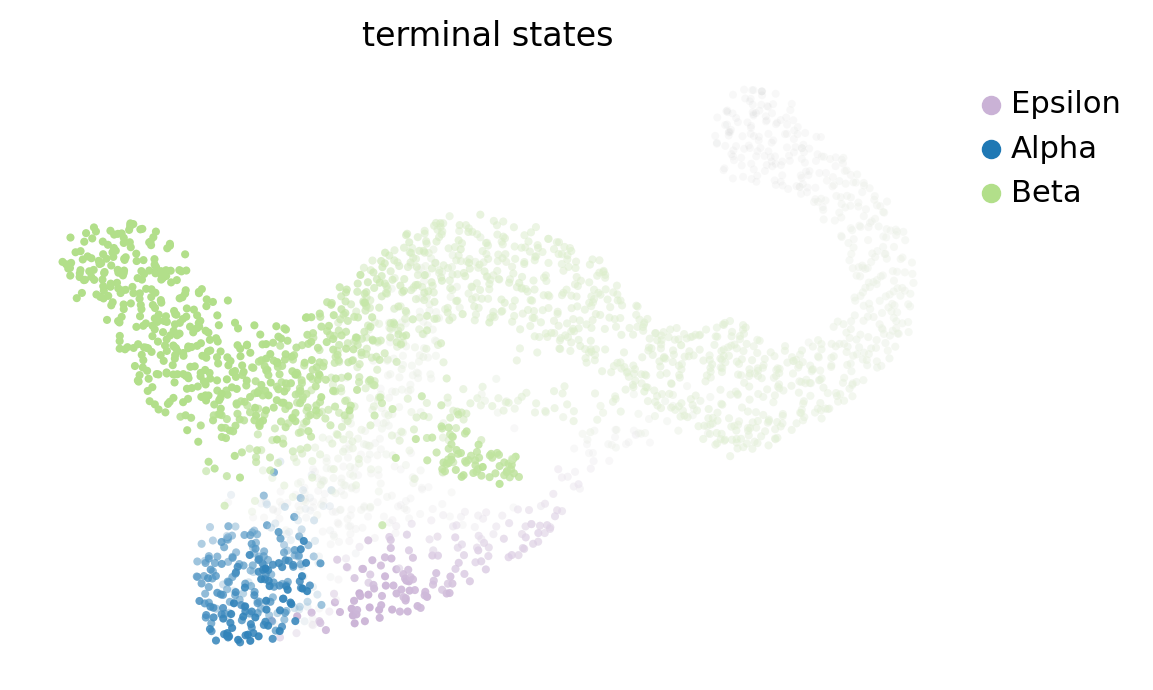

In [10]:
cr.pl.terminal_states(adata)

## Identify initial states

The same sort of analysis can now be repeated for the initial states, only that we use the function `cr.tl.initial_states` this time:

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode
Setting `softmax_scale=3.7951`
    Finish (0:00:09)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eig_bwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `.macrostates_memberships`
        `.macrostates`
    Finish (0:00:00)
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


/tmp/ipykernel_1912/1187097337.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, cluster_key="clusters")
/home/runner/work/cellrank_notebooks/cellrank_notebooks/cellrank/cellrank/tl/_init_term_states.py:104: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(
100%|██████████| 2531/2531 [00:03<00:00, 767.66cell/s]


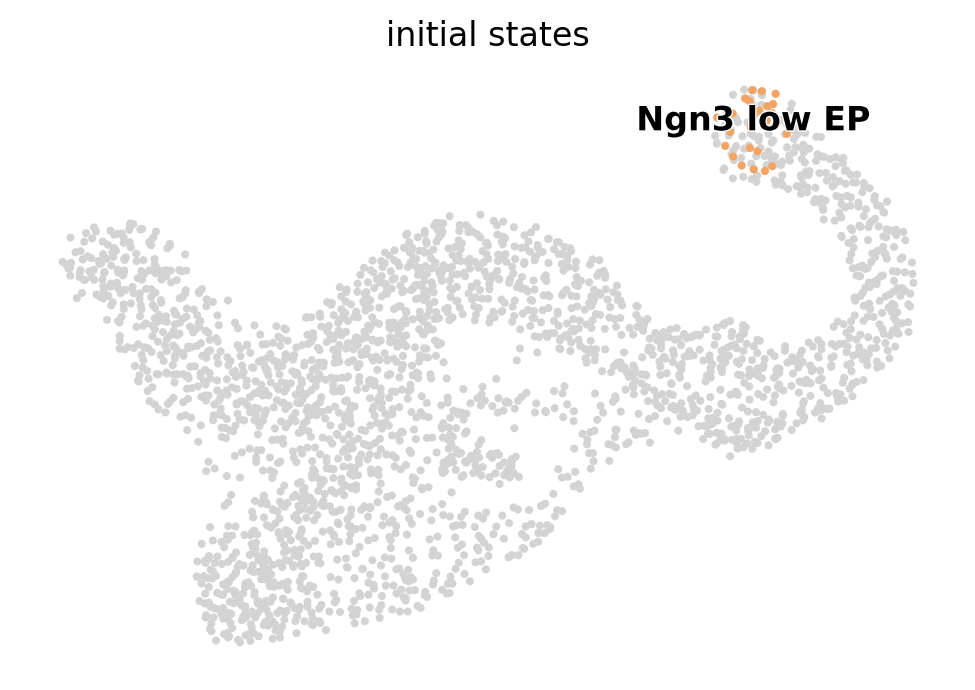

In [11]:
cr.tl.initial_states(adata, cluster_key="clusters")
cr.pl.initial_states(adata, discrete=True)

We found one initial state, located in the Ngn3 low EP cluster. 

## Compute fate maps

Once we know the terminal states, we can compute associated fate maps - for each cell, we ask how likely is the cell to develop towards each of the identified terminal states. 

Computing lineage probabilities towards terminal states
Computing absorption probabilities
Defaulting to `'gmres'` solver.
Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:00)


/tmp/ipykernel_1912/1878844763.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata)
100%|██████████| 3/3 [00:00<00:00, 33.46/s]


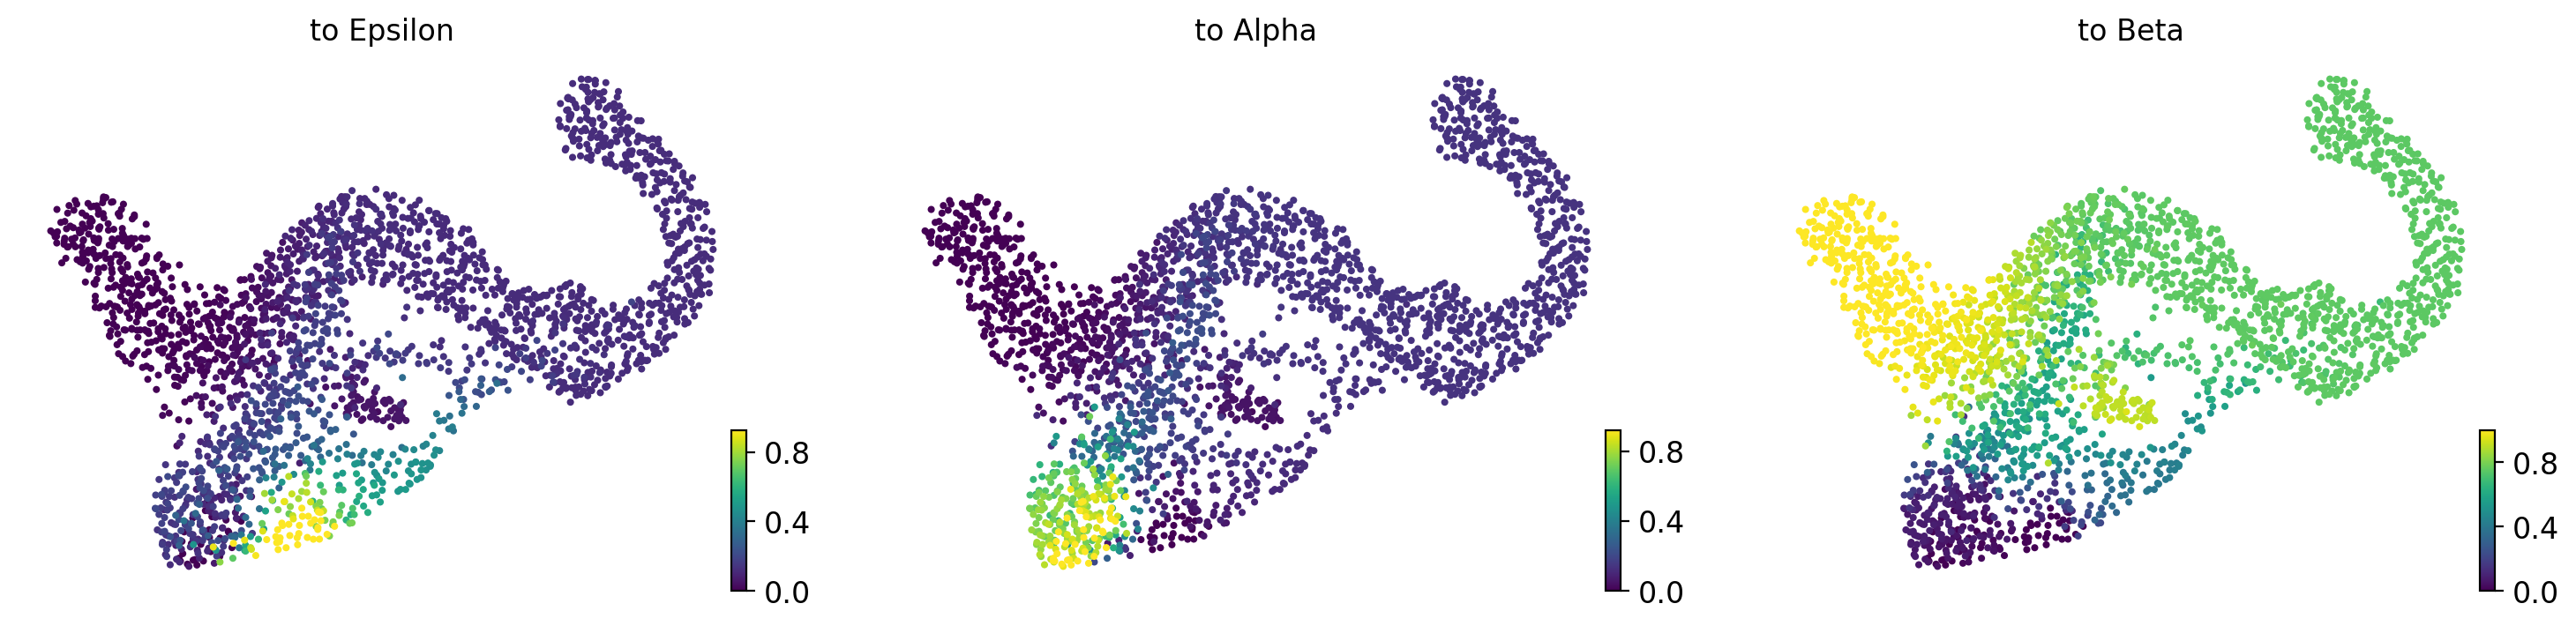

In [12]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

We can aggregate the above into a single, global fate map where we associate each terminal state with color and use the intensity of that color to show the fate of each individual cell:

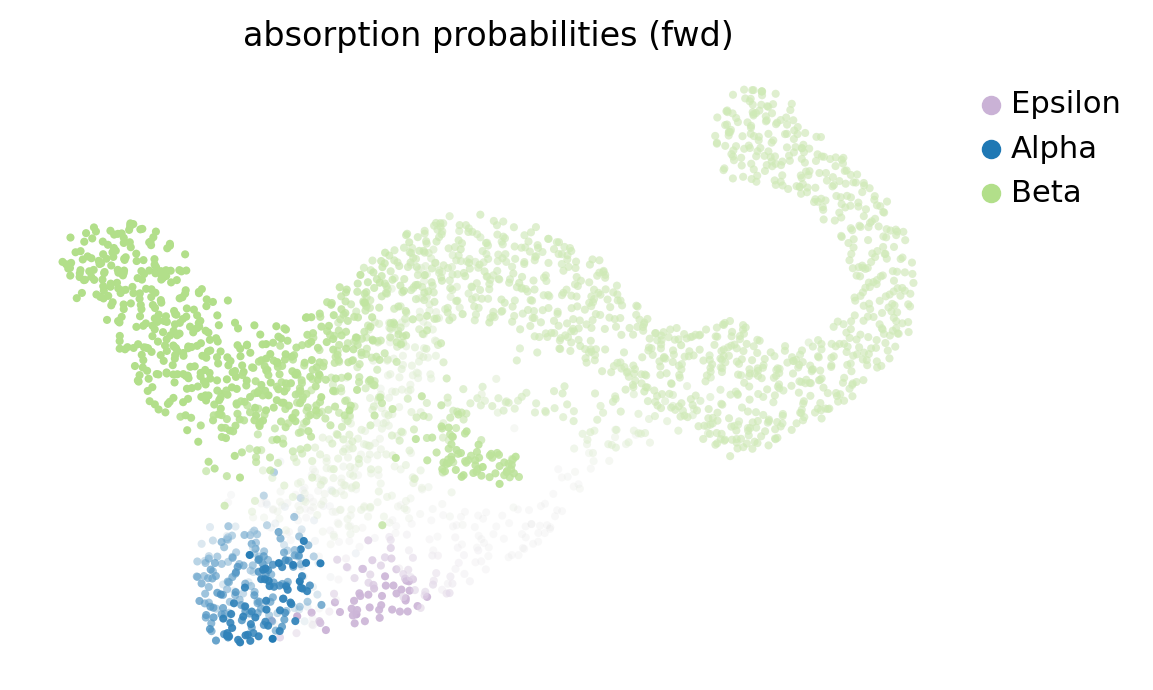

In [13]:
cr.pl.lineages(adata, same_plot=True)

This shows that the dominant terminal state at E15.5 is `Beta`, consistent with known biology, see e.g. <cite data-cite="bastidas-ponce:19">Bastidas-Ponce et al., Development 2019</cite>.

## Directed PAGA

We can further aggregate the individual fate maps into a cluster-level fate map using an adapted version of <cite data-cite="wolf:19">PAGA</cite> with directed edges. We first compute scVelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time) with CellRank identified `root_key` and `end_key`, which are the probabilities of being an initial or a terminal state, respectively.

In [14]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


Next, we can use the inferred pseudotime along with the initial and terminal states probabilities to compute the directed PAGA.

In [15]:
scv.tl.paga(
    adata,
    groups="clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


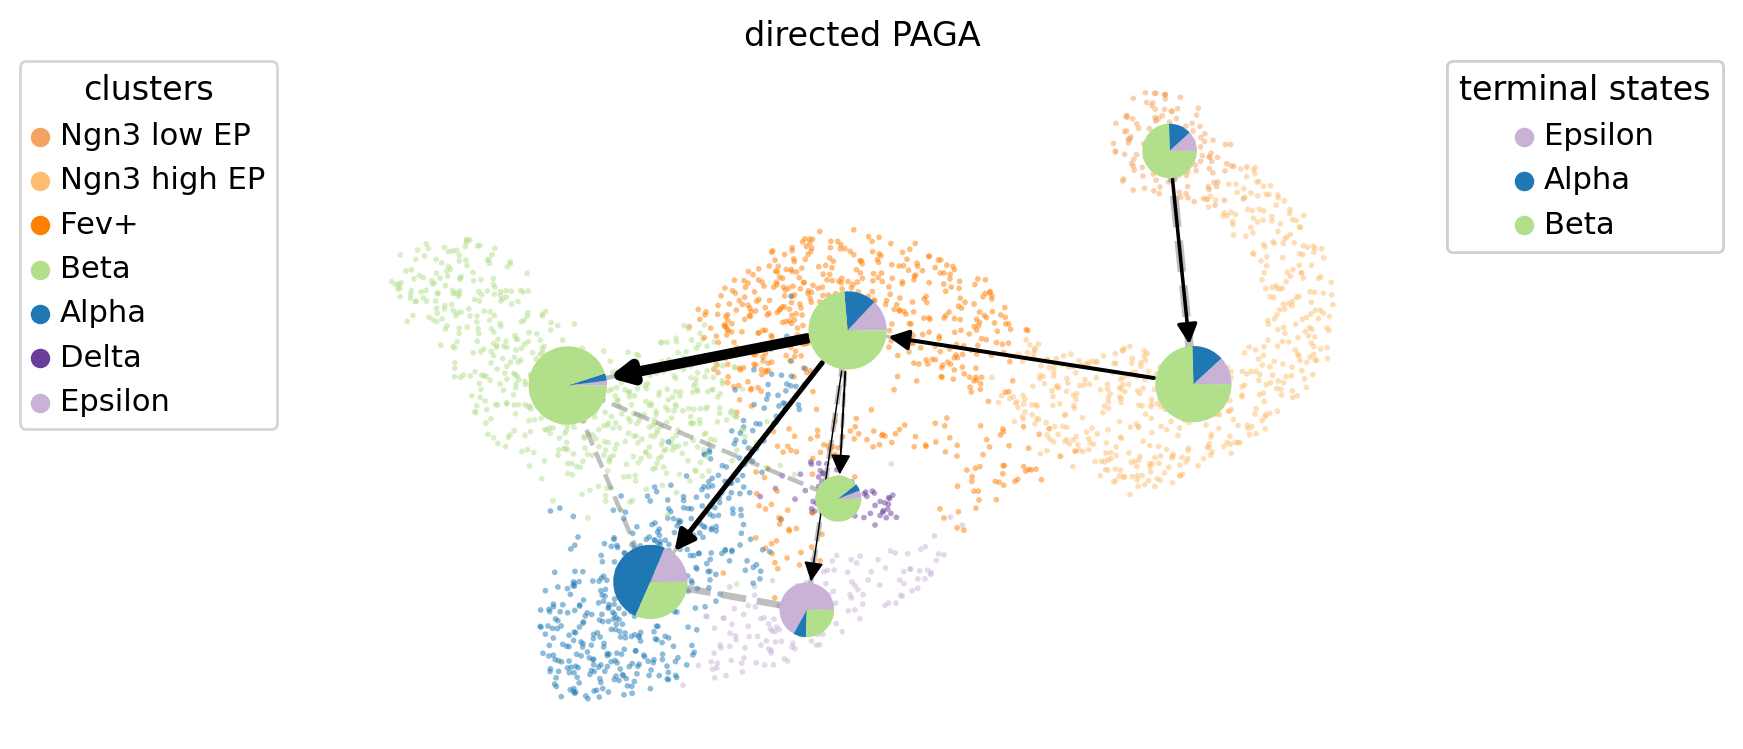

In [16]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="clusters",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=4,
    title="directed PAGA",
)

We use pie charts to show cell fates averaged per cluster. Edges between clusters are given by transcriptomic similarity between the clusters, just as in normal [PAGA](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.paga.html#scanpy.tl.paga). 

## Compute lineage drivers

We can compute the driver genes for all or just a subset of lineages. We can also restrict this to some subset of clusters by specifying `clusters=...` (not shown below). In the resulting dataframe, we also see the p-value, the corrected p-value (q-value) and the 95% confidence interval for the correlation statistic.

In [17]:
cr.tl.lineage_drivers(adata)

Computing correlations for lineages `['Epsilon' 'Alpha' 'Beta']` restricted to clusters `None` in layer `X` with `use_raw=False`
Adding `.lineage_drivers`
       `adata.var['to Epsilon corr']`
       `adata.var['to Alpha corr']`
       `adata.var['to Beta corr']`
    Finish (0:00:00)


/tmp/ipykernel_1912/1721556810.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata)


Epsilon corr   Epsilon pval   Epsilon qval  Epsilon ci low  \
index                                                                 
Ghrl         0.802445   0.000000e+00   0.000000e+00        0.788123   
Anpep        0.456913  7.362873e-136  7.362873e-133        0.425527   
Gm11837      0.449617  6.363280e-131  4.242187e-128        0.417977   
Irx2         0.399584  1.900033e-100   9.500166e-98        0.366326   
Ccnd2        0.384302   3.215020e-92   1.286008e-89        0.350590   
...               ...            ...            ...             ...   
Dlk1        -0.323105   1.065371e-63   1.253377e-61       -0.357566   
Gng12       -0.342605   4.652671e-72   7.157955e-70       -0.376540   
Nkx6-1      -0.349302   4.412792e-75   7.354653e-73       -0.383050   
Nnat        -0.357367   7.903944e-79   1.580789e-76       -0.390886   
Pdx1        -0.370467   3.608790e-85   8.019534e-83       -0.403603   

         Epsilon ci high  Alpha corr     Alpha pval     Alpha qval  \
index                                                                
Ghrl            0.815898   -0.102534   2.297277e-07   1.708013e-06   
Anpep           0.487202   -0.063882   1.298458e-03   4.477442e-03   
Gm11837         0.480167   -0.045986   2.068031e-02   4.854532e-02   
Irx2            0.431823    0.517187  3.359764e-182  3.359764e-179   
Ccnd2           0.417020    0.152544   1.074184e-14   1.732555e-13   
...                  ...         ...            ...            ...   
Dlk1           -0.287766   -0.168021   1.477940e-17   2.869787e-16   
Gng12          -0.307751   -0.330585   7.893953e-67   9.867441e-65   
Nkx6-1         -0.314622   -0.318417   8.753731e-62   8.753731e-60   
Nnat           -0.322901   -0.324287   3.462302e-64   4.073297e-62   
Pdx1           -0.336360   -0.332613   1.076884e-67   1.435846e-65   

         Alpha ci low  Alpha ci high  Beta corr      Beta pval      Beta qval  \
index                                                                           
Ghrl        -0.140933      -0.063827  -0.409512  4.724513e-106  6.749304e-104   
Anpep       -0.102589      -0.024982  -0.228948   1.018131e-31   2.867975e-30   
Gm11837     -0.084796      -0.007037  -0.238269   2.593335e-34   7.979493e-33   
Irx2         0.488060       0.545163  -0.640866   0.000000e+00   0.000000e+00   
Ccnd2        0.114262       0.190375  -0.351177   6.078976e-76   4.676135e-74   
...               ...            ...        ...            ...            ...   
Dlk1        -0.205637      -0.129910   0.325835   7.866709e-65   4.495262e-63   
Gng12       -0.364847      -0.295428   0.462703  7.139031e-140  2.379677e-137   
Nkx6-1      -0.352999      -0.282965   0.457422  3.293316e-136  9.409475e-134   
Nnat        -0.358716      -0.288976   0.466844  8.508624e-143  3.403450e-140   
Pdx1        -0.366821      -0.297507   0.481220  2.652301e-153  1.768201e-150   

         Beta ci low  Beta ci high  
index                               
Ghrl       -0.441431     -0.376559  
Anpep      -0.265541     -0.191696  
Gm11837    -0.274681     -0.201175  
Irx2       -0.663266     -0.617318  
Ccnd2      -0.384873     -0.316546  
...              ...           ...  
Dlk1        0.290562      0.360224  
Gng12       0.431521      0.492781  
Nkx6-1      0.426054      0.487693  
Nnat        0.435809      0.496770  
Pdx1        0.450709      0.510608  

[2000 rows x 15 columns]

Afterwards, we can plot the top 5 driver genes (based on the correlation), e.g. for the `Alpha` lineage:

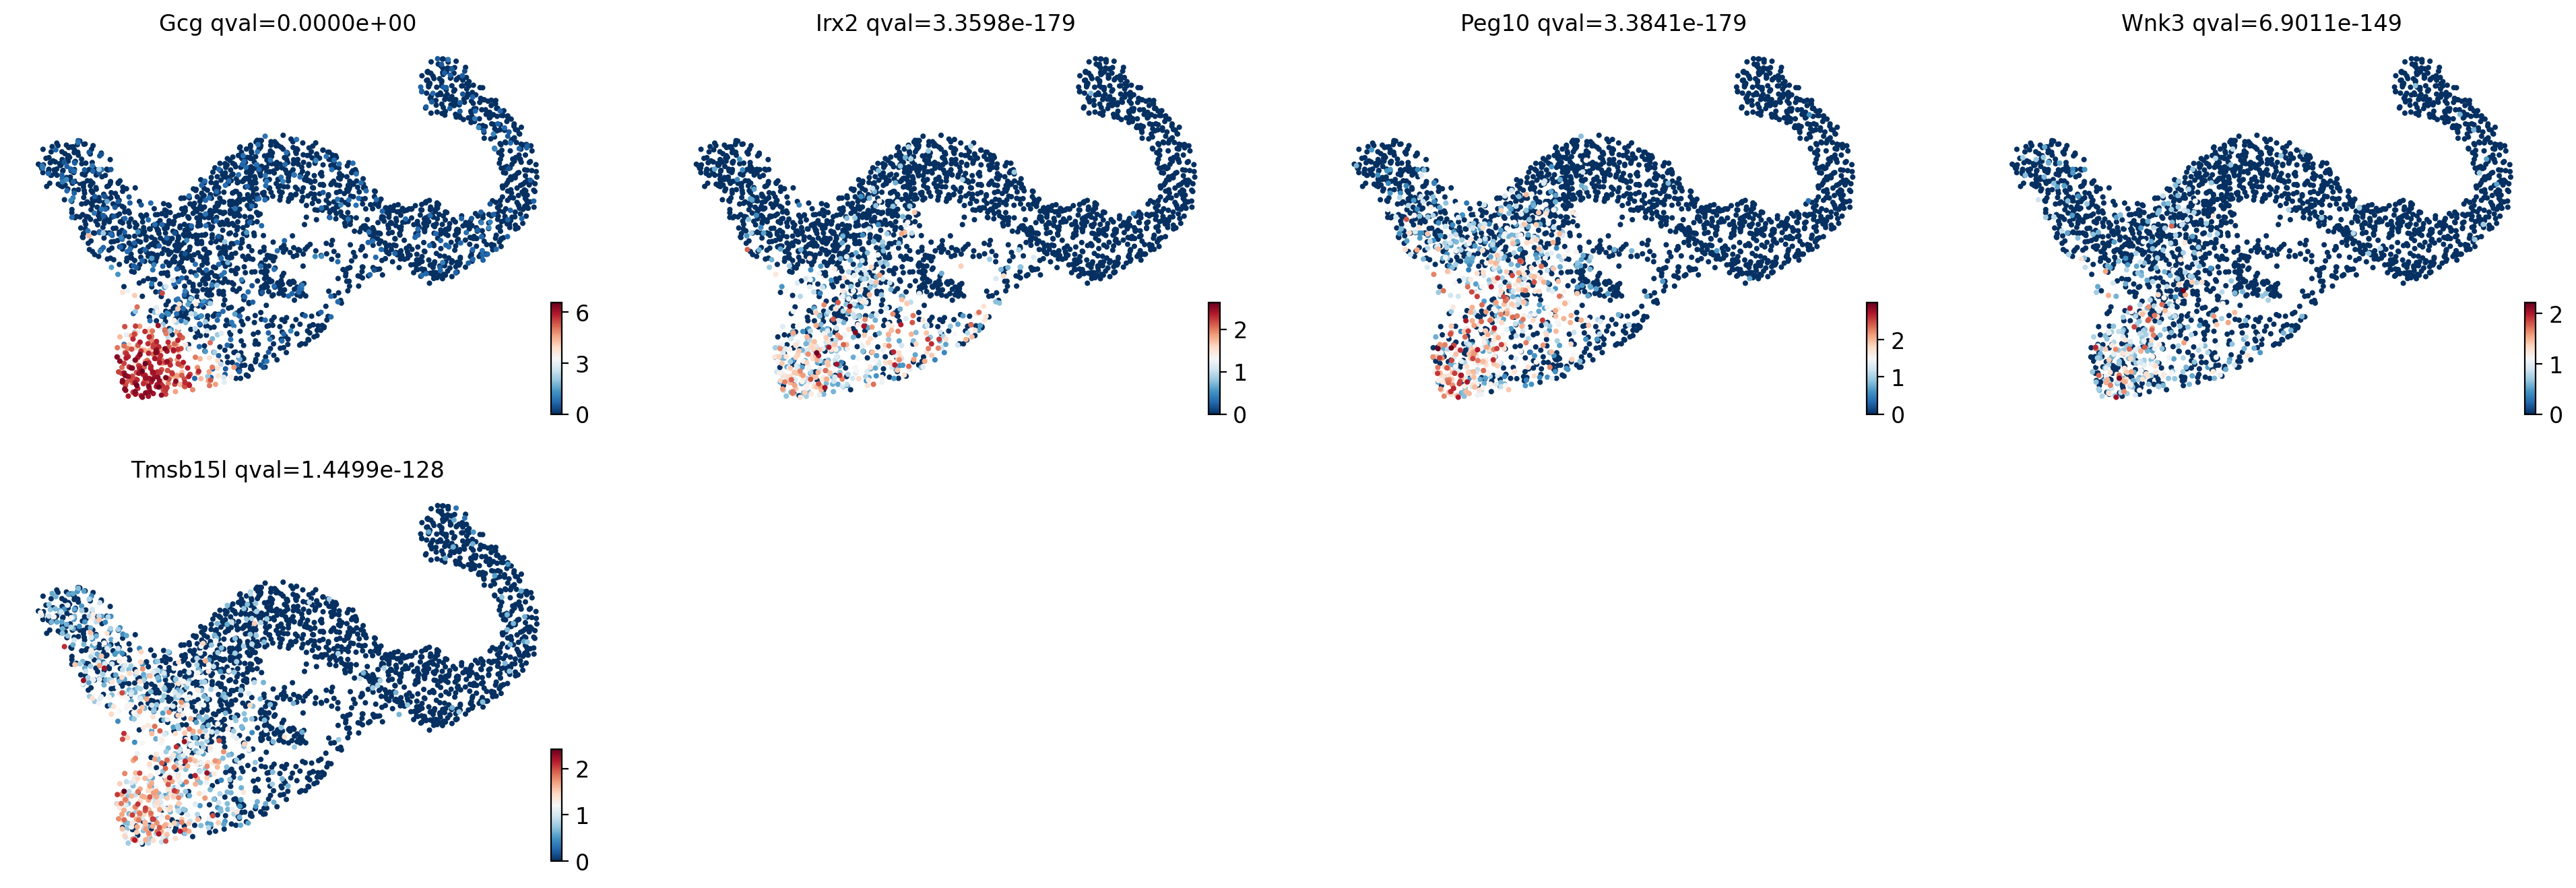

In [18]:
cr.pl.lineage_drivers(adata, lineage="Alpha", n_genes=5)

## Gene expression trends

The functions demonstrated above are the main functions of CellRank: computing initial and terminal states and probabilistic fate maps. We can use the computed probabilities now to e.g. smooth gene expression trends along lineages. 

Let's start with a temporal ordering for the cells. To get this, we can compute scVelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time), as computed previously, or alternatively, we can just use CellRank's initial states to compute a <cite data-cite="haghverdi:16">Diffusion pseudotime</cite>. 

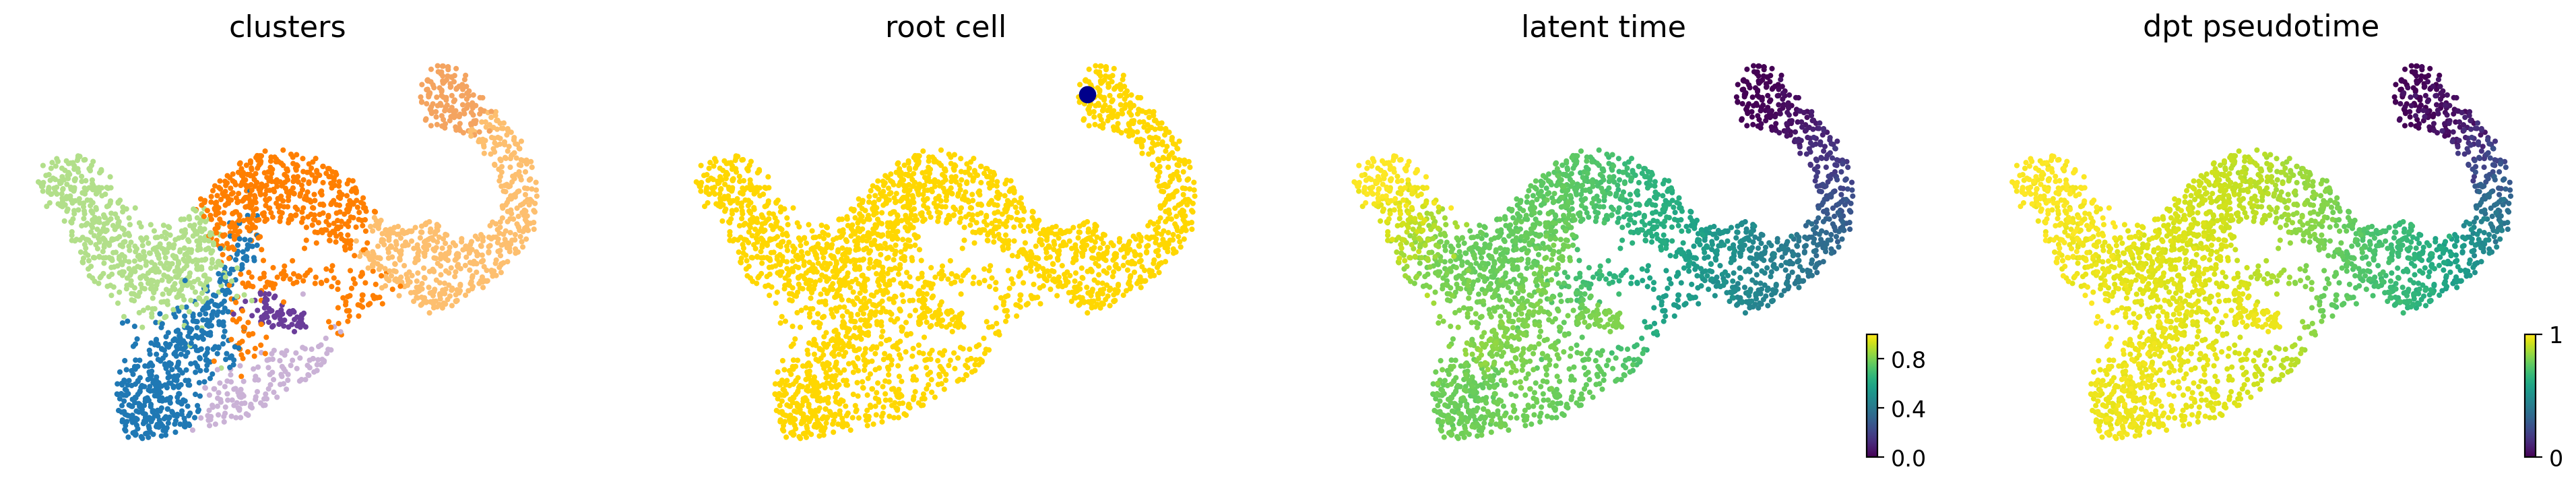

In [19]:
# compue DPT, starting from CellRank defined root cell
root_idx = np.where(adata.obs["initial_states"] == "Ngn3 low EP")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(
    adata,
    color=["clusters", root_idx, "latent_time", "dpt_pseudotime"],
    fontsize=16,
    cmap="viridis",
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=["clusters", "root cell", "latent time", "dpt pseudotime"],
)

We can plot dynamics of genes in pseudotime along individual trajectories, defined via the fate maps we computed above.

Computing trends using `1` core(s)
    Finish (0:00:00)
Plotting trends


100%|██████████| 3/3 [00:00<00:00,  5.23gene/s]


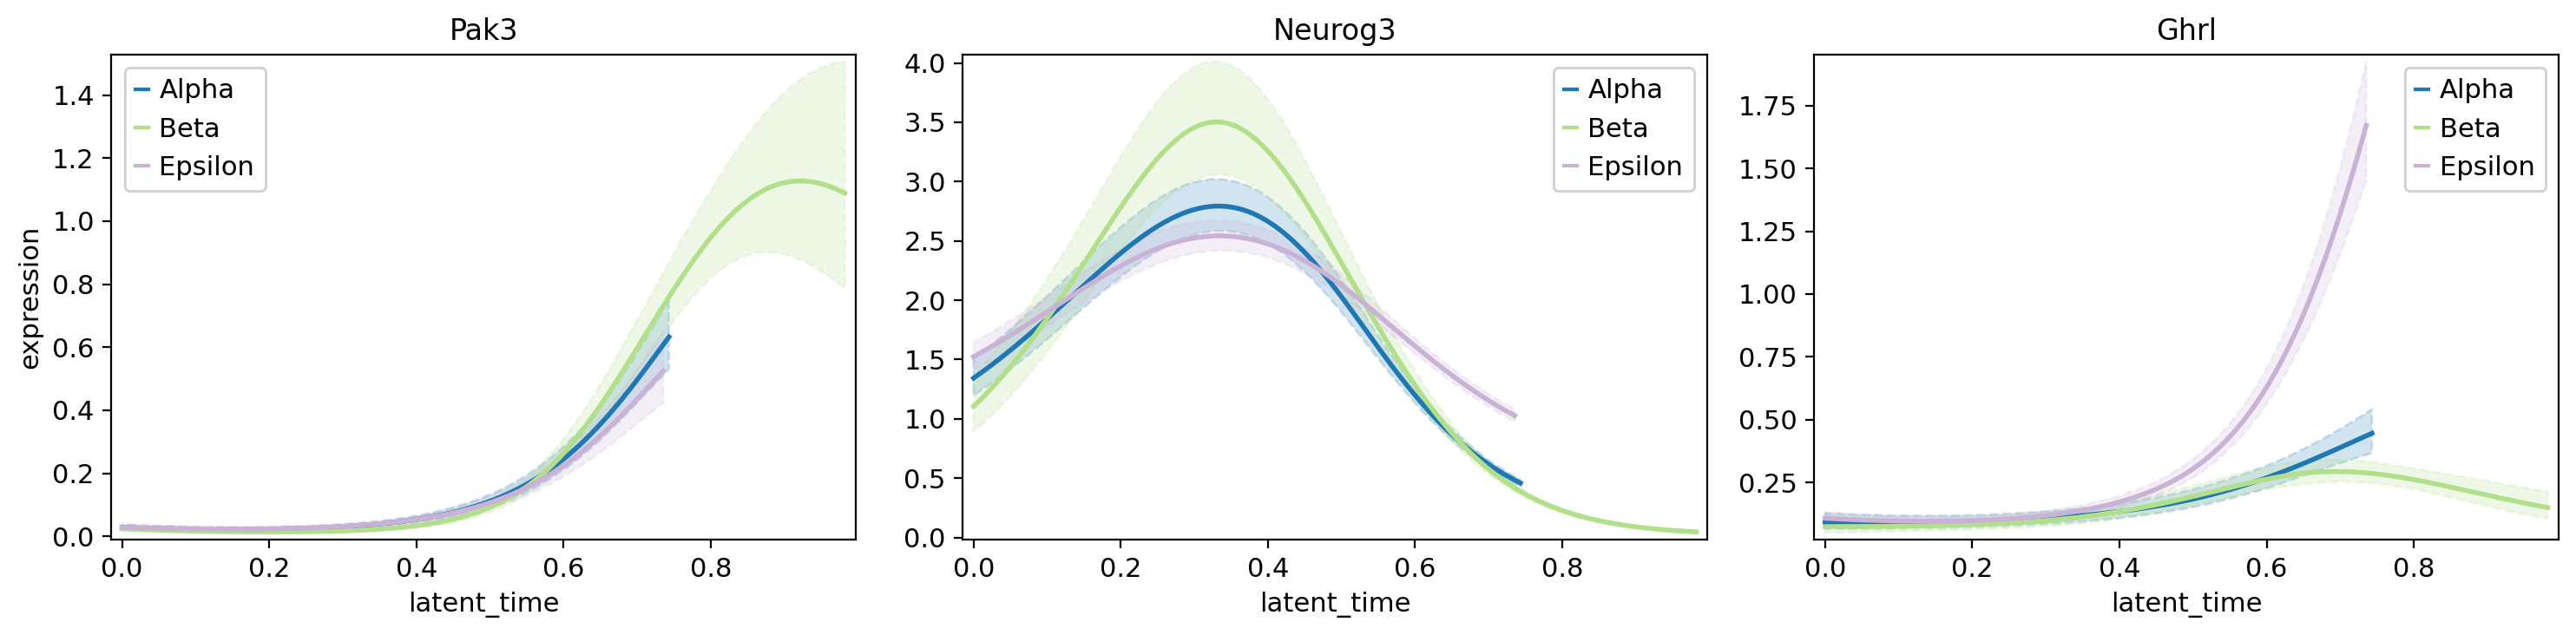

In [20]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["Pak3", "Neurog3", "Ghrl"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

We can also visualize the lineage drivers computed above in a heatmap. Below, we do this for the Alpha lineage, i.e. we smooth gene expression for the putative Alpha-drivers in pseudotime, using as cell-level weights the Alpha fate probabilities. We sort genes according to their peak in pseudotime, thus revealing a cascade of gene expression events. 

Computing trends using `1` core(s)
did not converge
did not converge
    Finish (0:00:15)


100%|██████████| 100/100 [00:15<00:00,  6.60gene/s]


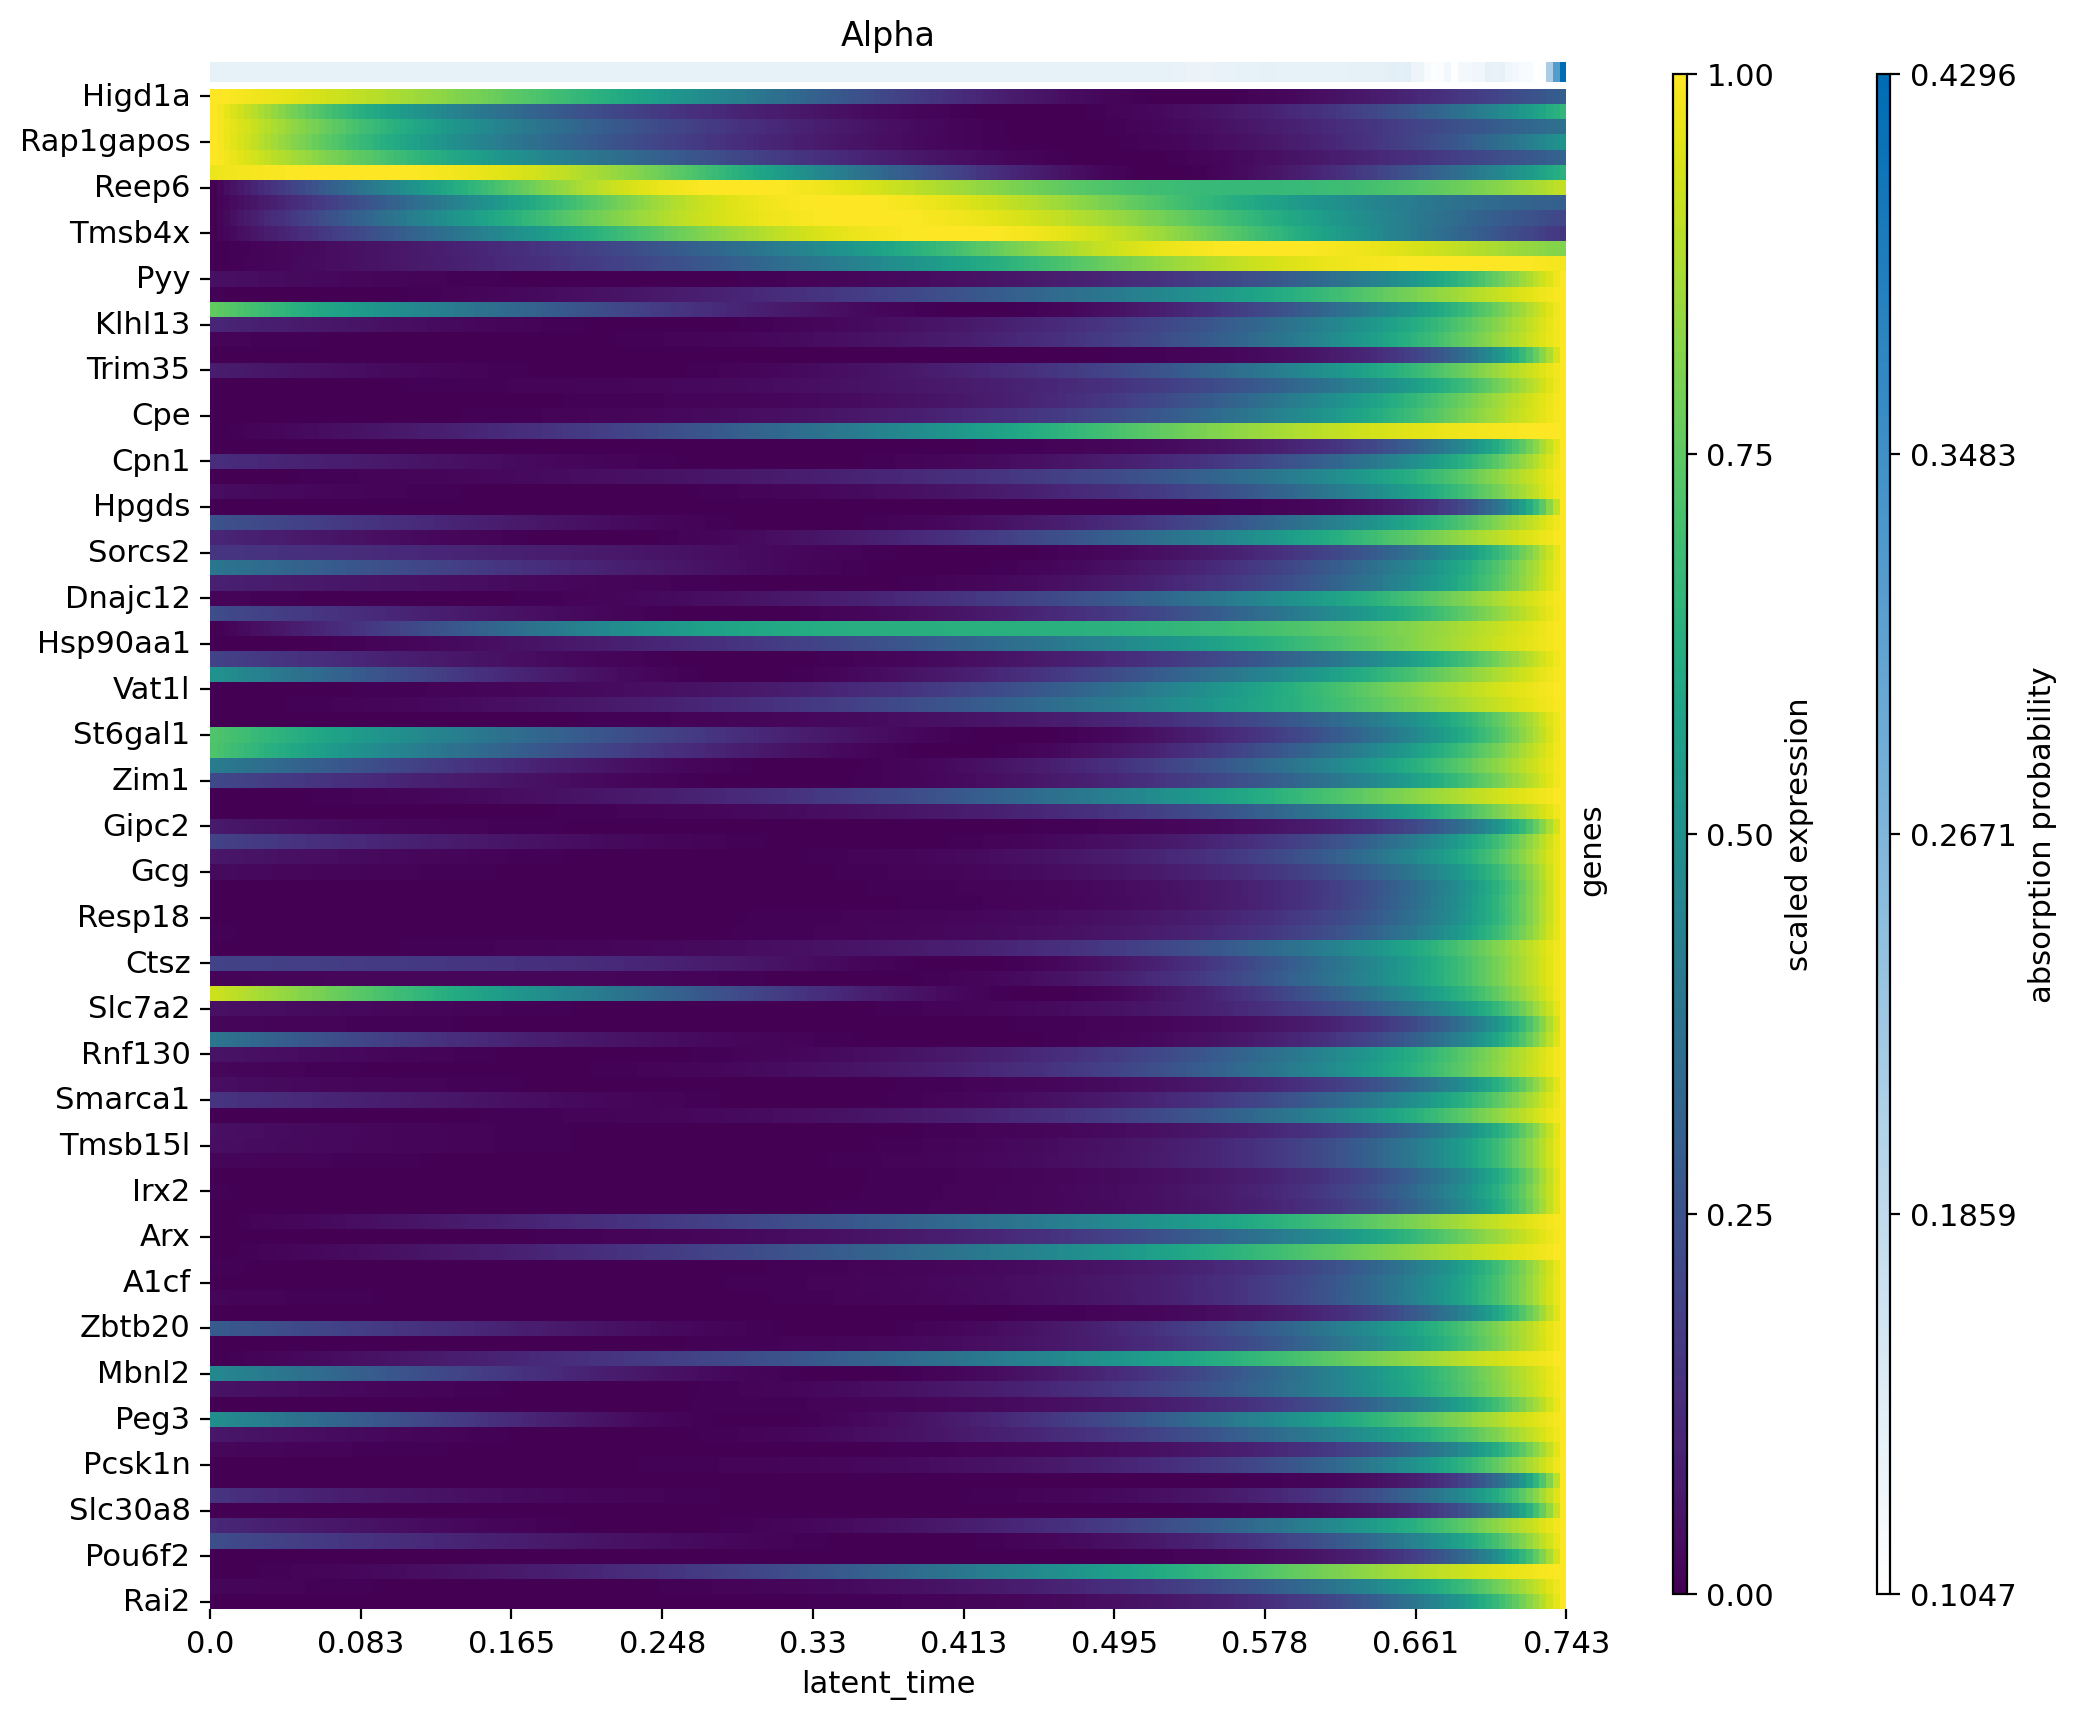

In [21]:
cr.pl.heatmap(
    adata,
    model,
    genes=adata.var["to Alpha corr"].sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="Alpha",
    n_jobs=1,
    backend="loky",
)

## What's next? 

Congratulations! You have successfully gone through some first computations with CellRank. If you want to learn more, you can check out:

- our **low level API**, unlocking the full potential of CellRank trough kernels and estimators, flexible classes that compute cell-cell transition probabilities (kernels) and aggregate these to formulate hypothesis about the underlying dynamics (estimators). See the [Kernels and estimators](https://cellrank.readthedocs.io/en/stable/kernels_and_estimators.html) tutorial. 
- how CellRank can be used **without RNA velocity**. See the [CellRank beyond RNA velocity](https://cellrank.readthedocs.io/en/stable/beyond_rna_velocity.html) tutorial. 
- CellRank [external](https://cellrank.readthedocs.io/en/stable/external_api.html), our interface to **third-party libraries**, giving you even more possibilities to model single-cell data based on Markov chains, conveniently though the CellRank interface. 